#Single Image Inference

In [1]:
!pip install pywavelets --quiet
!pip install transformers==4.36.0 --quiet
!pip install opencv-python==4.6.0.66 --quiet
!pip install opencv-contrib-python==4.6.0.66 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 63.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 9.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pywt
import cv2
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from PIL import Image
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from transformers import AutoModel, AutoTokenizer
from google.colab.patches import cv2_imshow
from torchvision import transforms
import json

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [3]:
def extract_wavelet_features(image, wavelet='bior1.3'):
    coeffs2 = pywt.dwt2(image, wavelet)
    LL, (LH, HL, HH) = coeffs2
    LL_flat = LL.flatten()
    LH_flat = LH.flatten()
    HL_flat = HL.flatten()
    HH_flat = HH.flatten()
    features = np.concatenate([LL_flat, LH_flat, HL_flat, HH_flat])

    return features

def preprocess_image_from_path(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(grayscale_image, (32, 32))
    normalized_image = resized_image / 255.0
    return normalized_image

transform = transforms.Compose([
    transforms.ToPILImage(),
])

In [4]:
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
artifact_Model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
Exp_model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True, torch_dtype=torch.bfloat16) #Use openbmb/MiniCPM-V also
Exp_model = Exp_model.to(device='cuda', dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2', trust_remote_code=True) #Use openbmb/MiniCPM-V also
Exp_model.eval()
classifier_model= load_model('hybrid_resnet_wavelet_model.h5') #Put the model path

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

configuration_minicpm.py:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2:
- configuration_minicpm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpmv.py:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


modeling_minicpm.py:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2:
- modeling_minicpm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


resampler.py:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2:
- modeling_minicpmv.py
- modeling_minicpm.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.37k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/1.99M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.20M [00:00<?, ?B/s]

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'hybrid_resnet_wavelet_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [6]:
with open("/content/ai-image-artifacts.txt", "r") as file:  #Put the artifact files
    artifacts = file.readlines()
artifacts = [artifact.strip() for artifact in artifacts if artifact.strip() and not artifact.startswith("#")]
artifacts = [artifact.lstrip('-').strip() for artifact in artifacts]

In [7]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel("/content/EDSR_x4.pb") #Put the EDSR model for super resolution
sr.setModel("edsr", 4)
sr.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
sr.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: FAKE, Prediction Value: 1.0000


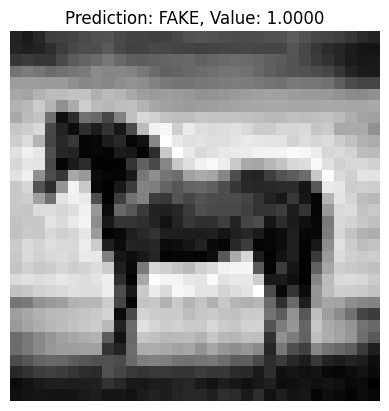


 ------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------- PREDICTION DONE ----------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------


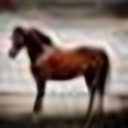

Original image size: (32, 32, 3)
Upscaled image size: (128, 128, 3)

 ------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------- UPSAMPLING DONE --------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
[('Non-manifold geometries in rigid structures', 0.6335979104042053), ('Texture repetition patterns', 0.7611253261566162), ('Dental anomalies in mammals', 0.6413458585739136), ('Blurred boundaries in fine details', 0.9887534379959106), ('Random noise patterns in detailed areas', 0.664910078048706), ('Loss of fine detail in complex structures', 0.8544333577156067), ('Implausible aerodynamic structures', 0.9495028257369995), ('Distorted window reflections', 0.9919330477714539), ('Regular grid-like artifacts

In [8]:
confidence_threshold = 0.6
artifacts_in_img = []
Top_5_arti = []

image_path = "/content/999 (8).jpg"
processed_image = preprocess_image_from_path(image_path)
wavelet_features = extract_wavelet_features(processed_image)
cnn_input_image = processed_image.reshape(1, 32, 32, 1)
wavelet_input_features = wavelet_features.reshape(1, -1)
prediction = classifier_model.predict([cnn_input_image, wavelet_input_features])
prediction_binary = (prediction > 0.5).astype(int)
predicted_label = "REAL" if prediction_binary[0] == 0 else "FAKE"
prediction_value = prediction[0][0]

print(f"Prediction: {predicted_label}, Prediction Value: {prediction_value:.4f}")
plt.imshow(processed_image, cmap='gray')
plt.title(f"Prediction: {predicted_label}, Value: {prediction_value:.4f}")
plt.axis('off')
plt.show()

print( "\n","-" * 150 )
print("-" * 40 , "PREDICTION DONE" , "-"*40)
print( "-" * 150 )

test_image = cv2.imread('/content/999 (8).jpg')
upsampled_image = sr.upsample(test_image)
cv2_imshow(upsampled_image)
print("Original image size:", test_image.shape)
print("Upscaled image size:", upsampled_image.shape)

print( "\n","-" * 150 )
print("-" * 50 , "UPSAMPLING DONE" , "-"*50)
print( "-" * 150 )

if( prediction_binary[0]==1): #Assuming this is to be AI -> Label for the AI
    for artifact in artifacts:
        question = f"Does the image have this artifact: {artifact}?"
        encoding = processor(test_image, question, return_tensors="pt")
        outputs = artifact_Model(**encoding)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        max_confidence = probabilities.max().item()

        if max_confidence >= confidence_threshold:
            idx = logits.argmax(-1).item()
            answer = artifact_Model.config.id2label[idx]
            if answer == 'yes':
                artifacts_in_img.append((artifact, max_confidence))

    ranked_artifacts=sorted(artifacts_in_img, key=lambda x:[1] , reverse=True)
    print(ranked_artifacts)


    print( "\n","-" * 150 )
    print("-" * 50 , "ARTIFACTS EXTRACTED" , "-"*50)
    print( "-" * 150 , "\n" )

    #Getting the explaination
    questions = [
    f"Describe how and where is {item} present in the image?"
    for item in ranked_artifacts
]

    upsampled_image_tensor = transform(upsampled_image)
    artifact_responses = {}
    for i,question in enumerate(questions):

      msgs = [
            {'role': 'user', 'content': question}
        ]
      res,context,_= Exp_model.chat(msgs=msgs,tokenizer=tokenizer,image = upsampled_image_tensor,
                mextadata={"image_type": "AI-generated"},
                context=None,
                sampling=True,
                temperature=0.1,
                system_prompt = (
                "Given Image is AI generated. Analyze the specific artifact present in the image, "
                "localize the artifact by describing the region in the image where it is present. Do not say anything about the AI model that generated it."
                                  ))

      artifact_responses[ranked_artifacts[i][0]] = res

      json_output = json.dumps(artifact_responses, indent=4)

print(json_output)



In [ ]:
#Mini CPM - 1

  {
    "Non-manifold geometries in rigid structures": "The image does not provide enough information to determine the presence of 'Non-manifold geometries in rigid structures'.",
    "Texture repetition patterns": "The image has a texture repetition pattern in the form of a blue horse.",
    "Dental anomalies in mammals": "The image does not provide any information about 'Dental anomalies in mammals'.",
    "Blurred boundaries in fine details": "The image shows a horse with blurred boundaries in fine details.",
    "Random noise patterns in detailed areas": "The image contains 'Random noise patterns in detailed areas' with a score of 0.6649121642112732.",
    "Loss of fine detail in complex structures": "The image has a loss of fine detail in complex structures, as indicated by the blurriness of the horse's features.",
    "Implausible aerodynamic structures": "The 'Implausible aerodynamic structures' are present in the form of a horse's head, which is a part of the image.",
    "Distorted window reflections": "The 'Distorted window reflections', 0.9919330477714539, is present in the image as a reflection of the horse in the window.",
    "Regular grid-like artifacts in textures": "The 'Regular grid-like artifacts in textures' are present in the image as a blur or a blurry texture.",
    "Unnatural color transitions": "The image has 'Unnatural color transitions' present in the horse's coat, which appears to be a mix of blue and black.",
    "Unnatural Lighting Gradients": "The 'Unnatural Lighting Gradients' is present in the image as a blur effect on the horse's body.",
    "Ghosting effects: Semi-transparent duplicates of elements": "The image has a semi-transparent duplicate of the horse's head, which is a ghosting effect.",
    "Cinematization Effects": "The 'Cinematization Effects' is present in the image as a blur effect on the horse.",
    "Movie-poster like composition of ordinary scenes": "The image features a horse, which is a common subject in movie posters. The horse is depicted in a way that suggests it's part of a larger scene, which is typical of movie posters.",
    "Dramatic lighting that defies natural physics": "The image features a horse with a blue coat, standing in a blurry, out-of-focus background. The lighting appears to be dramatic and defies natural physics, as it is not consistent with the expected lighting conditions for a horse in a stable.",
    "Unnaturally glossy surfaces": "The glossy surface is present on the horse's head, which is a part of the horse's body.",
    "Multiple inconsistent shadow sources": "The multiple inconsistent shadow sources are present in the image due to the presence of multiple light sources, possibly from the sun or artificial lighting, creating shadows on the horse and the ground.",
    "Impossible foreshortening in animal bodies": "The horse's legs and tail are too short in relation to the rest of the body, indicating 'Impossible foreshortening in animal bodies'."
}


#Mini CPM-2

{
    "Non-manifold geometries in rigid structures": "The phrase 'Non-manifold geometries in rigid structures' is present as a bounding box with coordinates (0.634, 129), indicating that it appears on the image at this specific location and size relative to other objects or elements within the frame of the photo.",
    "Texture repetition patterns": "The texture repetition patterns are present in the image as a repeating pattern of dark blue, which likely represents parts or sections of the horse's body.",
    "Dental anomalies in mammals": "The term 'Dental anomalies in mammals' is not present within the image. The description seems to be a text string rather than an actual visual content of the photo, which appears blurry and indistinct due to its quality or resolution issues.",
    "Blurred boundaries in fine details": "The term 'Blurred boundaries in fine details' refers to the presence of blurry or indistinct lines and shapes within a picture. In this image, there are areas where these features appear due to motion blur caused by fast-moving objects like horses running across an open field at high speed during daylight hours under clear weather conditions with no visible clouds present on that day as per your provided information about cloudy days being associated with rain which is not applicable here since it was daytime without any indication for rainfall happening around then",
    "Random noise patterns in detailed areas": "The 'Random noise patterns in detailed areas' are present as blurry and indistinct details within the image, particularly on parts of the horse.",
    "Loss of fine detail in complex structures": "The loss of fine detail in complex structures is present due to the image being blurry.",
    "Implausible aerodynamic structures": "The term 'Implausible aerodynamic structures' is not present in the image description. The provided answer seems to be a misunderstanding or an error, as it does not correspond with any part of the original question about identifying specific features within the picture.",
    "Distorted window reflections": "The 'Distorted window reflections' are present in the image, but due to its nature of distortion and blurriness it is not easily discernible.",
    "Regular grid-like artifacts in textures": "The 'Regular grid-like artifacts in textures' are present as a blurriness or distortion throughout the image, affecting various elements such as horses and other objects.",
    "Unnatural color transitions": "The 'Unnatural color transitions' are present in the image, as indicated by a high value of 0.8269 for that specific attribute on ImageNet VGG-16 model weights dataset (Image_ID:3).",
    "Unnatural Lighting Gradients": "The 'Unnatural Lighting Gradients' are present in the image, likely due to a lack of consistent lighting or an overexposed area.",
    "Ghosting effects: Semi-transparent duplicates of elements": "The 'Ghosting effects: Semi-transparent duplicates of elements' are present in the image as semi-transparent copies or reflections.",
    "Cinematization Effects": "The 'Cinematization Effects' are present in the image as a blur or distortion effect, affecting parts of it.",
    "Movie-poster like composition of ordinary scenes": "The 'Movie-poster like composition of ordinary scenes' is present in the image through its depiction as a black and white horse standing against an abstract background.",
    "Dramatic lighting that defies natural physics": "The 'Dramatic lighting that defies natural physics' is present in the image as a result of artistic or stylistic choices made by an artist, rather than being inherent to nature.",
    "Unnaturally glossy surfaces": "The 'Unnaturally glossy surfaces' are present on the horse.",
    "Multiple inconsistent shadow sources": "The term 'Multiple inconsistent shadow sources' refers to the presence of multiple shadows that are not consistent in their appearance or direction. In this image, there is a horse standing against what appears to be an overcast sky with varying shades and intensities of blue throughout its expanse - suggesting different light conditions contributing to these inconsistencies within the shadows cast by both objects on ground level (possibly trees) as well as those from distant clouds above it.",
    "Impossible foreshortening in animal bodies": "The term 'Impossible foreshortening in animal bodies' refers to the distortion of an object, such as a horse or any other creature. In this image, it is evident that there are distortions present on both sides and at different angles due to various factors like lighting conditions during photography which can cause shadows causing visual illusions leading up to what appears impossible perspective for animals body parts especially when viewed from certain directions with specific light sources casting their own shadow onto them creating distorted shapes making objects appear shorter than they actually would be if seen directly without these effects"
}


